In [1]:
import csv
import numpy as np
import Loader
import tensorflow as tf
import Transformer
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError
#use for dark mode
plt.rcParams["font.family"] = "serif"
plt.style.use('dark_background')

In [9]:
compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)

['PostEra-SAM-UNK-2684b532-12' 'GoStar-gvk_125468971'
 'enamine-PV-001916729968' 'CHEMBL3182384' 'GoStar-gvk_125485558'
 'PostEra-PET-UNK-7fb4f80a-1' 'PostEra-MAT-POS-a54ce14d-3' 'CHEMBL1370630'
 'GoStar-gvk_125468798' 'PostEra-ALP-POS-88a7a97e-38']


['GoStar-gvk_125509532ZINC68197423PostEra-ALP-POS-ecbed2ba-8GoStar-gvk_125391823GoStar-gvk_124987259ZINC3872277PostEra-MAT-POS-4223bc15-41CHEMBL309760GoStar-gvk_12539205225258088']

## Just Docking and Fusion

In [6]:
dataLabels = labelsTrain[0:20]
trainData = compoundDataTrain[:,0:20]
testData = compoundDataTest[:,0:20]
testData = compoundDataValidate[:,0:20]

['docking_score_0', 'docking_score_1', 'docking_score_2', 'docking_score_3', 'docking_score_4', 'docking_score_5', 'docking_score_6', 'docking_score_7', 'docking_score_8', 'docking_score_9', 'fusion_score_0', 'fusion_score_1', 'fusion_score_2', 'fusion_score_3', 'fusion_score_4', 'fusion_score_5', 'fusion_score_6', 'fusion_score_7', 'fusion_score_8', 'fusion_score_9']


In [35]:
def runIteration(split, epochsCount):
    
    #reload the data, (ensures data is shuffled)
    _, _, _, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
    _, _, _, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
    _, _, _, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)
    
    #transform the data, just remove any non fusion and docking 
    trainData = compoundDataTrain[:,0:20]
    testData = compoundDataTest[:,0:20]
    valData = compoundDataValidate[:,0:20]

    #normalize data
    trainData, testData, valData = Transformer.normalizeData(
        trainData, testData, valData, newMean=0, newStd=1)
    #outputs, classification here
    classVal = Transformer.toBinaryClassification(activitiesValidate)
    classTrain = Transformer.toBinaryClassification(activitiesTrain)
    
    #split data (0=1)
    trainData = trainData[0: int(split*len(trainData)) , :] #use %
    classTrain = classTrain[0: int(split*len(classTrain))] #use %
    
    print(split, len(trainData), "samples used.")
    
    l1Reg = keras.regularizers.L1(.001)
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False
    )
    inputDim = np.shape(trainData)[1] #how many inputs
    #build and run model
    model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(inputDim, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(40, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(80, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(120, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(120, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(60, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(30, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(2, activation='relu', kernel_regularizer = l1Reg)
        ])

    model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True), metrics=['accuracy'])

    history = model.fit(trainData, classTrain, validation_data = (valData, classVal), 
        epochs=epochsCount, batch_size=4, verbose = 1) #verbose = 0 for no printing
    
    return model, history


dataSegments = [1, .9, .75, .5, .25, .1]
modelHistories = [] #data for each of the models
averageRuns = 3
epochs = 30

for seg in dataSegments:
    segHist = []
    for i in range(averageRuns):
        tempModel, tempHistory = runIteration(seg, epochs)
        
        if(tempHistory.history["accuracy"][-1] <= .60): #terrible train performance, redo
            i = i-1 #don't use this iteration
            continue
            
        print(100*seg, '\b%', i, " iteration:")
        print("Val Accuracy: ", tempHistory.history["val_accuracy"][-1])
        print("Train Accuracy: ", tempHistory.history["accuracy"][-1])
        segHist.append(tempHistory)
    modelHistories.append(segHist) #histories for this partition of data

1 2717 samples used.
Epoch 1/30
680/680 [==============================] - 4s 3ms/step - loss: 1.2247 - accuracy: 0.4902 - val_loss: 0.6881 - val_accuracy: 0.6118
Epoch 2/30
680/680 [==============================] - 2s 3ms/step - loss: 0.6756 - accuracy: 0.6198 - val_loss: 0.6759 - val_accuracy: 0.6118
Epoch 3/30
680/680 [==============================] - 2s 2ms/step - loss: 0.6723 - accuracy: 0.6198 - val_loss: 0.6756 - val_accuracy: 0.6118
Epoch 4/30
680/680 [==============================] - 2s 3ms/step - loss: 0.6716 - accuracy: 0.6198 - val_loss: 0.6765 - val_accuracy: 0.6118
Epoch 5/30
680/680 [==============================] - 2s 2ms/step - loss: 0.6719 - accuracy: 0.6198 - val_loss: 0.6753 - val_accuracy: 0.6118
Epoch 6/30
680/680 [==============================] - 2s 3ms/step - loss: 0.6717 - accuracy: 0.6198 - val_loss: 0.6751 - val_accuracy: 0.6118
Epoch 7/30
680/680 [==============================] - 2s 2ms/step - loss: 0.6717 - accuracy: 0.6198 - val_loss: 0.6751 - val_ac

612/612 [==============================] - 1s 2ms/step - loss: 0.6585 - accuracy: 0.6740 - val_loss: 0.6501 - val_accuracy: 0.6824
Epoch 24/30
612/612 [==============================] - 2s 3ms/step - loss: 0.6576 - accuracy: 0.6712 - val_loss: 0.6508 - val_accuracy: 0.6824
Epoch 25/30
612/612 [==============================] - 2s 3ms/step - loss: 0.6578 - accuracy: 0.6736 - val_loss: 0.6545 - val_accuracy: 0.6676
Epoch 26/30
612/612 [==============================] - 2s 2ms/step - loss: 0.6584 - accuracy: 0.6703 - val_loss: 0.6482 - val_accuracy: 0.6912
Epoch 27/30
612/612 [==============================] - 2s 3ms/step - loss: 0.6568 - accuracy: 0.6691 - val_loss: 0.6479 - val_accuracy: 0.6794
Epoch 28/30
612/612 [==============================] - 2s 3ms/step - loss: 0.6569 - accuracy: 0.6753 - val_loss: 0.6478 - val_accuracy: 0.6794
Epoch 29/30
612/612 [==============================] - 2s 3ms/step - loss: 0.6566 - accuracy: 0.6683 - val_loss: 0.6498 - val_accuracy: 0.6735
Epoch 30/30

Epoch 19/30
612/612 [==============================] - 1s 2ms/step - loss: 0.6598 - accuracy: 0.6683 - val_loss: 0.6644 - val_accuracy: 0.6118
Epoch 20/30
612/612 [==============================] - 1s 2ms/step - loss: 0.6594 - accuracy: 0.6720 - val_loss: 0.6580 - val_accuracy: 0.6706
Epoch 21/30
612/612 [==============================] - 1s 2ms/step - loss: 0.6588 - accuracy: 0.6757 - val_loss: 0.6594 - val_accuracy: 0.6794
Epoch 22/30
612/612 [==============================] - 1s 2ms/step - loss: 0.6579 - accuracy: 0.6716 - val_loss: 0.6568 - val_accuracy: 0.6676
Epoch 23/30
612/612 [==============================] - 1s 2ms/step - loss: 0.6583 - accuracy: 0.6724 - val_loss: 0.6573 - val_accuracy: 0.6794
Epoch 24/30
612/612 [==============================] - 1s 2ms/step - loss: 0.6580 - accuracy: 0.6744 - val_loss: 0.6568 - val_accuracy: 0.6794
Epoch 25/30
612/612 [==============================] - 2s 2ms/step - loss: 0.6580 - accuracy: 0.6732 - val_loss: 0.6571 - val_accuracy: 0.6765

Epoch 11/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6750 - accuracy: 0.6679 - val_loss: 0.6831 - val_accuracy: 0.6529
Epoch 12/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6738 - accuracy: 0.6760 - val_loss: 0.6727 - val_accuracy: 0.6735
Epoch 13/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6694 - accuracy: 0.6760 - val_loss: 0.6719 - val_accuracy: 0.6765
Epoch 14/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6706 - accuracy: 0.6782 - val_loss: 0.6699 - val_accuracy: 0.6735
Epoch 15/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6667 - accuracy: 0.6745 - val_loss: 0.6674 - val_accuracy: 0.6765
Epoch 16/30
340/340 [==============================] - 1s 2ms/step - loss: 0.6655 - accuracy: 0.6775 - val_loss: 0.6648 - val_accuracy: 0.6735
Epoch 17/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6660 - accuracy: 0.6789 - val_loss: 0.6644 - val_accuracy: 0.6706

Epoch 7/30
340/340 [==============================] - 1s 2ms/step - loss: 0.6995 - accuracy: 0.6605 - val_loss: 0.6812 - val_accuracy: 0.6706
Epoch 8/30
340/340 [==============================] - 1s 2ms/step - loss: 0.6905 - accuracy: 0.6532 - val_loss: 0.6783 - val_accuracy: 0.6706
Epoch 9/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6884 - accuracy: 0.6635 - val_loss: 0.6745 - val_accuracy: 0.6706
Epoch 10/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6821 - accuracy: 0.6657 - val_loss: 0.6736 - val_accuracy: 0.6706
Epoch 11/30
340/340 [==============================] - 1s 2ms/step - loss: 0.6835 - accuracy: 0.6657 - val_loss: 0.6683 - val_accuracy: 0.6735
Epoch 12/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6795 - accuracy: 0.6657 - val_loss: 0.6666 - val_accuracy: 0.6706
Epoch 13/30
340/340 [==============================] - 1s 3ms/step - loss: 0.6777 - accuracy: 0.6635 - val_loss: 0.6685 - val_accuracy: 0.6676
Ep

Epoch 30/30
170/170 [==============================] - 1s 3ms/step - loss: 0.6584 - accuracy: 0.6892 - val_loss: 0.6658 - val_accuracy: 0.6765
25.0%% 2  iteration:
Val Accuracy:  0.6764705777168274
Train Accuracy:  0.6892489194869995
0.1 271 samples used.
Epoch 1/30
68/68 [==============================] - 3s 11ms/step - loss: 3.7910 - accuracy: 0.6052 - val_loss: 2.6697 - val_accuracy: 0.6118
Epoch 2/30
68/68 [==============================] - 0s 4ms/step - loss: 1.9515 - accuracy: 0.6015 - val_loss: 1.3737 - val_accuracy: 0.6118
Epoch 3/30
68/68 [==============================] - 0s 4ms/step - loss: 1.1336 - accuracy: 0.6015 - val_loss: 0.9798 - val_accuracy: 0.6118
Epoch 4/30
68/68 [==============================] - 0s 4ms/step - loss: 0.9267 - accuracy: 0.6015 - val_loss: 0.8763 - val_accuracy: 0.6118
Epoch 5/30
68/68 [==============================] - 0s 4ms/step - loss: 0.8553 - accuracy: 0.6015 - val_loss: 0.8348 - val_accuracy: 0.6118
Epoch 6/30
68/68 [=========================

Partition: 100 %, Train Acc:  0.6496135294437408 Val Acc:  0.6455882489681244
Partition: 90.0 %, Train Acc:  0.6725289622942606 Val Acc:  0.6823529402414957
Partition: 75.0 %, Train Acc:  0.6836033463478088 Val Acc:  0.6808823347091675
Partition: 50.0 %, Train Acc:  0.6823760469754537 Val Acc:  0.6686274409294128
Partition: 25.0 %, Train Acc:  0.673785001039505 Val Acc:  0.6720588207244873
Partition: 10.0 %, Train Acc:  0.6826568245887756 Val Acc:  0.6529411872227987


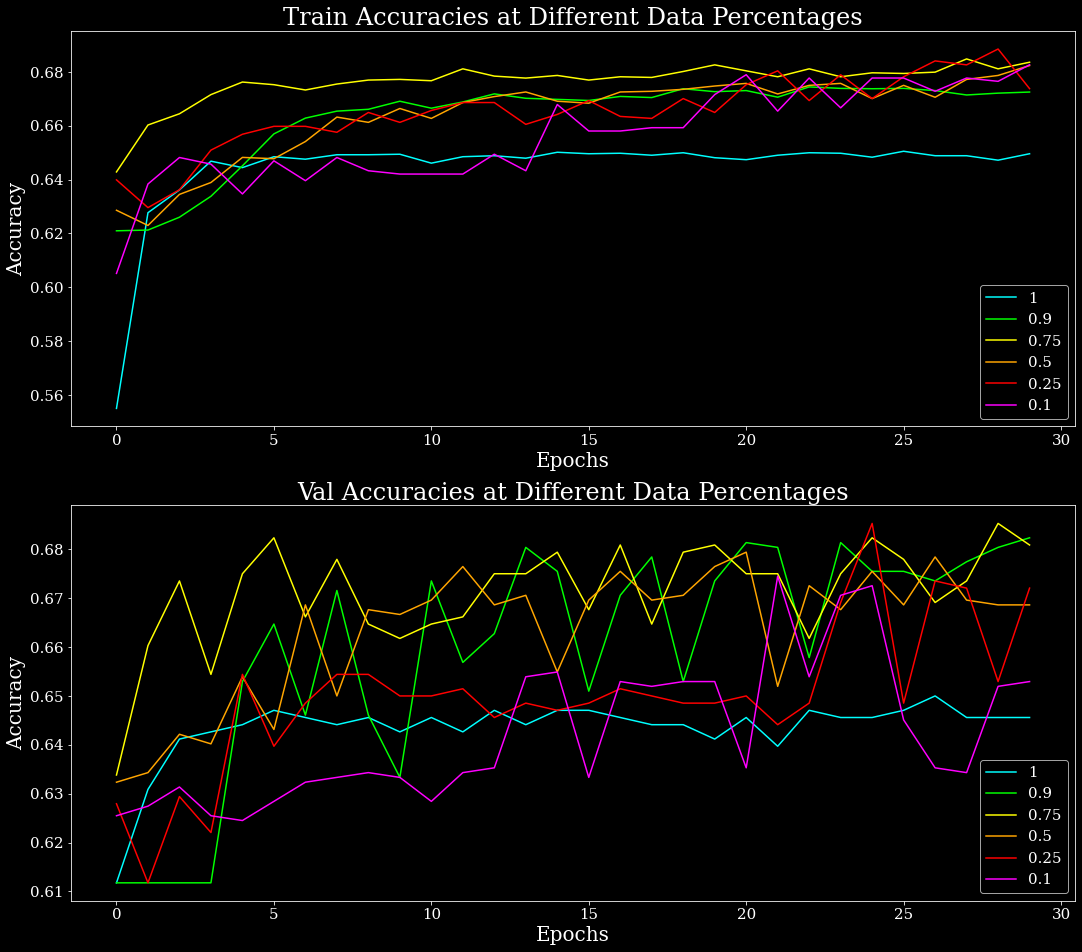

In [51]:
fig, ax = plt.subplots(2, figsize=(18,16))
colors = ["cyan", "lime", "yellow", "orange", "red", "magenta"]

for i in range(len(dataSegments)):
    allAcc = []
    allAccVal = []
    for j in range(len(modelHistories[i])): #get accuracies formatted nicely
        allAcc.append(modelHistories[i][j].history["accuracy"])
        allAccVal.append(modelHistories[i][j].history["val_accuracy"])
    
    avrAcc = np.average(allAcc, axis=0) #average all the accuracies
    avrAccVal = np.average(allAccVal, axis=0) #average all the accuracies
    
    print("Partition:", 100*dataSegments[i], "\b%, Train Acc: ", avrAcc[-1], "Val Acc: ", avrAccVal[-1])
    
    ax[0].plot(avrAcc, label=dataSegments[i], color=colors[i])
    ax[1].plot(avrAccVal, label=dataSegments[i], color=colors[i])
    
    
ax[0].set_title("Train Accuracies at Different Data Percentages", fontsize = 24)
ax[1].set_title("Val Accuracies at Different Data Percentages", fontsize = 24)

for i in range(2):
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].legend(loc = 'lower right', fontsize = 15)
    ax[i].set_xlabel("Epochs", fontsize = 20)
    ax[i].set_ylabel("Accuracy", fontsize = 20)

## Just docking and fusion but regression
It's gonna be so bad

In [54]:
def runIteration(split, epochsCount):
    
    #reload the data, (ensures data is shuffled)
    _, _, _, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
    _, _, _, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
    _, _, _, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)
    
    #transform the data, just remove any non fusion and docking 
    trainData = compoundDataTrain[:,0:20]
    testData = compoundDataTest[:,0:20]
    valData = compoundDataValidate[:,0:20]

    #normalize data
    trainData, testData, valData = Transformer.normalizeData(
        trainData, testData, valData, newMean=0, newStd=1)
    
    #split data (0=1)
    trainData = trainData[0: int(split*len(trainData)) , :] #use %
    activitiesTrain = activitiesTrain[0: int(split*len(activitiesTrain))] #use %
    
    print(split, len(trainData), "samples used.")
    
    l1Reg = keras.regularizers.L1(.001)
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False
    )
    inputDim = np.shape(trainData)[1] #how many inputs
    #build and run model
    
    model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(inputDim, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(40, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(80, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(120, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(120, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(60, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(30, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(1, activation='relu', kernel_regularizer = l1Reg)
        ])

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['MeanSquaredError'])

    history = model.fit(trainData, activitiesTrain, validation_data = (valData, activitiesValidate), 
        epochs=epochsCount, batch_size=4, verbose = 1) #verbose = 0 for no printing
    
    return model, history


dataSegments = [1, .9, .75, .5, .25, .1]
modelHistories = [] #data for each of the models
averageRuns = 3
epochs = 30

for seg in dataSegments:
    segHist = []
    for i in range(averageRuns):
        tempModel, tempHistory = runIteration(seg, epochs)
        
        if(tempHistory.history["mean_squared_error"][-1] >= 12): #terrible train performance, redo
            i = i-1 #don't use this iteration
            continue
            
        print(100*seg, '\b%', i, " iteration:")
        print("Val Error: ", tempHistory.history["val_mean_squared_error"][-1])
        print("Train Error: ", tempHistory.history["mean_squared_error"][-1])
        segHist.append(tempHistory)
    modelHistories.append(segHist) #histories for this partition of data

1 2717 samples used.
Epoch 1/30
680/680 [==============================] - 5s 3ms/step - loss: 11.5710 - mean_squared_error: 9.2539 - val_loss: 9.9956 - val_mean_squared_error: 8.1856
Epoch 2/30
680/680 [==============================] - 2s 3ms/step - loss: 9.8484 - mean_squared_error: 8.2570 - val_loss: 9.5716 - val_mean_squared_error: 8.1663
Epoch 3/30
680/680 [==============================] - 2s 3ms/step - loss: 9.4621 - mean_squared_error: 8.1990 - val_loss: 9.2400 - val_mean_squared_error: 8.1060
Epoch 4/30
680/680 [==============================] - 2s 3ms/step - loss: 9.2350 - mean_squared_error: 8.2011 - val_loss: 9.1714 - val_mean_squared_error: 8.2309
Epoch 5/30
680/680 [==============================] - 2s 3ms/step - loss: 8.9804 - mean_squared_error: 8.1118 - val_loss: 9.0273 - val_mean_squared_error: 8.2250
Epoch 6/30
680/680 [==============================] - 2s 3ms/step - loss: 8.8407 - mean_squared_error: 8.0961 - val_loss: 8.7055 - val_mean_squared_error: 8.0184
Epoch 

612/612 [==============================] - 2s 3ms/step - loss: 8.4691 - mean_squared_error: 7.8423 - val_loss: 8.7426 - val_mean_squared_error: 8.1413
Epoch 10/30
612/612 [==============================] - 2s 3ms/step - loss: 8.3354 - mean_squared_error: 7.7521 - val_loss: 8.7609 - val_mean_squared_error: 8.1935
Epoch 11/30
612/612 [==============================] - 2s 3ms/step - loss: 8.2402 - mean_squared_error: 7.6920 - val_loss: 8.9940 - val_mean_squared_error: 8.4650
Epoch 12/30
612/612 [==============================] - 2s 3ms/step - loss: 8.1214 - mean_squared_error: 7.6027 - val_loss: 8.7400 - val_mean_squared_error: 8.2357
Epoch 13/30
612/612 [==============================] - 2s 3ms/step - loss: 8.0886 - mean_squared_error: 7.5920 - val_loss: 8.6853 - val_mean_squared_error: 8.1978
Epoch 14/30
612/612 [==============================] - 2s 3ms/step - loss: 7.9393 - mean_squared_error: 7.4607 - val_loss: 8.5754 - val_mean_squared_error: 8.1086
Epoch 15/30
612/612 [=============

Epoch 29/30
612/612 [==============================] - 2s 3ms/step - loss: 7.2644 - mean_squared_error: 6.8375 - val_loss: 9.0596 - val_mean_squared_error: 8.6314
Epoch 30/30
612/612 [==============================] - 2s 3ms/step - loss: 7.2530 - mean_squared_error: 6.8247 - val_loss: 9.1030 - val_mean_squared_error: 8.6770
90.0% 1  iteration:
Val Error:  8.67700481414795
Train Error:  6.824666976928711
0.9 2445 samples used.
Epoch 1/30
612/612 [==============================] - 4s 3ms/step - loss: 14.6416 - mean_squared_error: 14.0863 - val_loss: 9.3243 - val_mean_squared_error: 9.1708
Epoch 2/30
612/612 [==============================] - 2s 3ms/step - loss: 9.1987 - mean_squared_error: 9.0521 - val_loss: 9.4194 - val_mean_squared_error: 9.2727
Epoch 3/30
612/612 [==============================] - 2s 3ms/step - loss: 9.2142 - mean_squared_error: 9.0769 - val_loss: 9.3718 - val_mean_squared_error: 9.2346
Epoch 4/30
612/612 [==============================] - 2s 3ms/step - loss: 9.1938 -

510/510 [==============================] - 1s 3ms/step - loss: 7.7194 - mean_squared_error: 7.2590 - val_loss: 8.7127 - val_mean_squared_error: 8.2542
Epoch 19/30
510/510 [==============================] - 1s 3ms/step - loss: 7.7474 - mean_squared_error: 7.2958 - val_loss: 8.7201 - val_mean_squared_error: 8.2729
Epoch 20/30
510/510 [==============================] - 1s 3ms/step - loss: 7.7075 - mean_squared_error: 7.2636 - val_loss: 8.8315 - val_mean_squared_error: 8.3869
Epoch 21/30
510/510 [==============================] - 1s 3ms/step - loss: 7.5761 - mean_squared_error: 7.1362 - val_loss: 8.7224 - val_mean_squared_error: 8.2854
Epoch 22/30
510/510 [==============================] - 1s 3ms/step - loss: 7.5560 - mean_squared_error: 7.1215 - val_loss: 8.6883 - val_mean_squared_error: 8.2573
Epoch 23/30
510/510 [==============================] - 1s 3ms/step - loss: 7.4520 - mean_squared_error: 7.0213 - val_loss: 8.4985 - val_mean_squared_error: 8.0684
Epoch 24/30
510/510 [=============

340/340 [==============================] - 1s 3ms/step - loss: 23.3826 - mean_squared_error: 23.3765 - val_loss: 22.8084 - val_mean_squared_error: 22.8023
Epoch 27/30
340/340 [==============================] - 1s 3ms/step - loss: 23.3826 - mean_squared_error: 23.3765 - val_loss: 22.8085 - val_mean_squared_error: 22.8023
Epoch 28/30
340/340 [==============================] - 1s 3ms/step - loss: 23.3826 - mean_squared_error: 23.3765 - val_loss: 22.8084 - val_mean_squared_error: 22.8023
Epoch 29/30
340/340 [==============================] - 1s 3ms/step - loss: 23.3826 - mean_squared_error: 23.3765 - val_loss: 22.8084 - val_mean_squared_error: 22.8023
Epoch 30/30
340/340 [==============================] - 1s 3ms/step - loss: 23.3826 - mean_squared_error: 23.3765 - val_loss: 22.8085 - val_mean_squared_error: 22.8023
0.5 1358 samples used.
Epoch 1/30
340/340 [==============================] - 3s 4ms/step - loss: 12.4441 - mean_squared_error: 9.8102 - val_loss: 10.5449 - val_mean_squared_erro

Epoch 4/30
170/170 [==============================] - 1s 3ms/step - loss: 9.7685 - mean_squared_error: 8.1385 - val_loss: 9.8758 - val_mean_squared_error: 8.2999
Epoch 5/30
170/170 [==============================] - 1s 3ms/step - loss: 9.5448 - mean_squared_error: 8.0130 - val_loss: 9.9955 - val_mean_squared_error: 8.5053
Epoch 6/30
170/170 [==============================] - 1s 3ms/step - loss: 9.4090 - mean_squared_error: 7.9551 - val_loss: 9.7550 - val_mean_squared_error: 8.3365
Epoch 7/30
170/170 [==============================] - 1s 3ms/step - loss: 9.2163 - mean_squared_error: 7.8279 - val_loss: 10.0258 - val_mean_squared_error: 8.6620
Epoch 8/30
170/170 [==============================] - 1s 3ms/step - loss: 9.0614 - mean_squared_error: 7.7294 - val_loss: 9.6282 - val_mean_squared_error: 8.3253
Epoch 9/30
170/170 [==============================] - 1s 3ms/step - loss: 9.2351 - mean_squared_error: 7.9558 - val_loss: 9.4843 - val_mean_squared_error: 8.2283
Epoch 10/30
170/170 [======

Epoch 24/30
170/170 [==============================] - 1s 3ms/step - loss: 7.1249 - mean_squared_error: 6.2808 - val_loss: 9.0835 - val_mean_squared_error: 8.2491
Epoch 25/30
170/170 [==============================] - 1s 3ms/step - loss: 6.9585 - mean_squared_error: 6.1265 - val_loss: 9.2872 - val_mean_squared_error: 8.4566
Epoch 26/30
170/170 [==============================] - 1s 3ms/step - loss: 6.6864 - mean_squared_error: 5.8561 - val_loss: 9.2832 - val_mean_squared_error: 8.4590
Epoch 27/30
170/170 [==============================] - 1s 3ms/step - loss: 6.6509 - mean_squared_error: 5.8302 - val_loss: 9.9540 - val_mean_squared_error: 9.1393
Epoch 28/30
170/170 [==============================] - 1s 3ms/step - loss: 6.5101 - mean_squared_error: 5.6944 - val_loss: 9.4750 - val_mean_squared_error: 8.6674
Epoch 29/30
170/170 [==============================] - 1s 3ms/step - loss: 6.8340 - mean_squared_error: 6.0289 - val_loss: 9.2695 - val_mean_squared_error: 8.4731
Epoch 30/30
170/170 [=

Partition: 100 %, Train Err:  6.84648060798645 Val Err:  9.1825590133667
Partition: 90.0 %, Train Err:  7.537901560465495 Val Err:  8.791896184285482
Partition: 75.0 %, Train Err:  6.721843878428142 Val Err:  8.094539642333984
Partition: 50.0 %, Train Err:  6.004640102386475 Val Err:  9.081593990325928
Partition: 25.0 %, Train Err:  5.7922210693359375 Val Err:  9.235706011454264
Partition: 10.0 %, Train Err:  3.9683539072672525 Val Err:  10.909477869669596


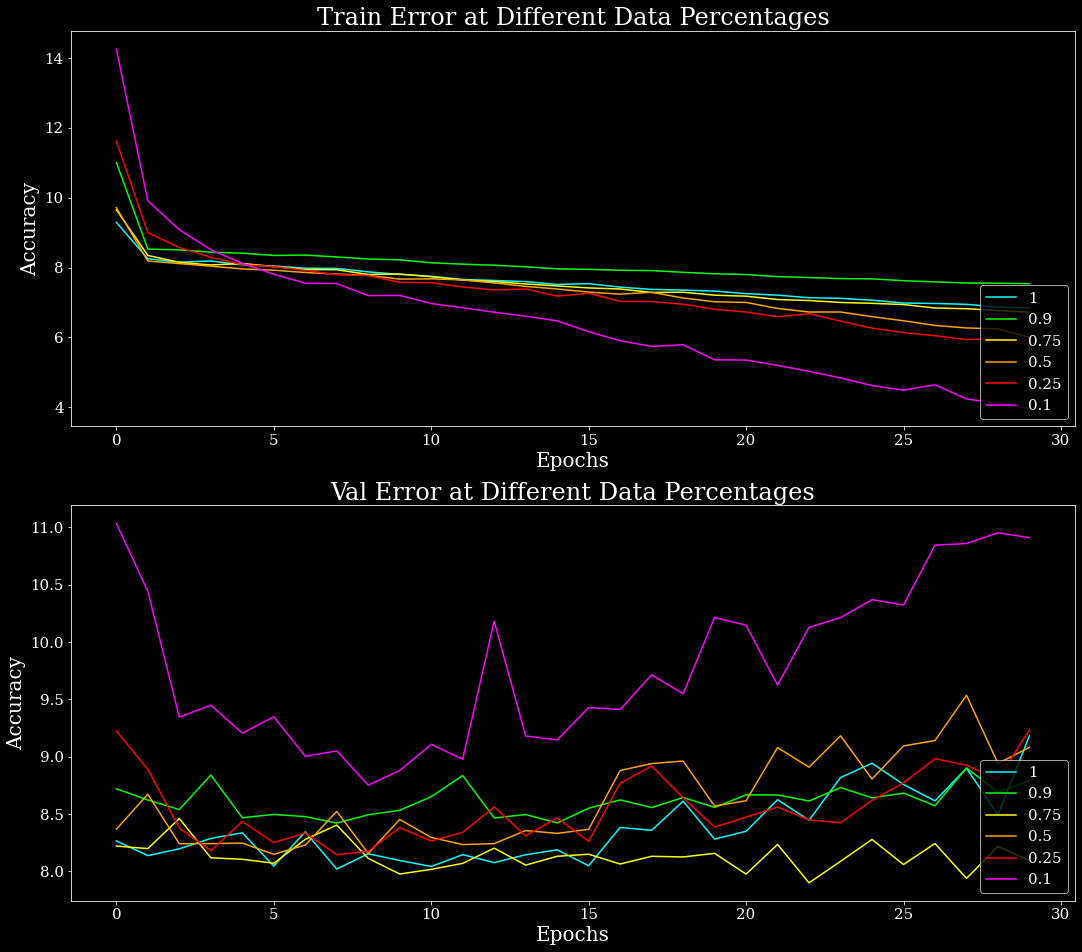

In [58]:
fig, ax = plt.subplots(2, figsize=(18,16))
colors = ["cyan", "lime", "yellow", "orange", "red", "magenta"]

for i in range(len(dataSegments)):
    allErr = []
    allErrVal = []
    for j in range(len(modelHistories[i])): #get accuracies formatted nicely
        allErr.append(modelHistories[i][j].history["mean_squared_error"])
        allErrVal.append(modelHistories[i][j].history["val_mean_squared_error"])
    
    avrErr = np.average(allErr, axis=0) #average all the accuracies
    avrErrVal = np.average(allErrVal, axis=0) #average all the accuracies
    
    print("Partition:", 100*dataSegments[i], "\b%, Train Err: ", avrErr[-1], "Val Err: ", avrErrVal[-1])
    
    ax[0].plot(avrErr, label=dataSegments[i], color=colors[i])
    ax[1].plot(avrErrVal, label=dataSegments[i], color=colors[i])
    
    
ax[0].set_title("Train Error at Different Data Percentages", fontsize = 24)
ax[1].set_title("Val Error at Different Data Percentages", fontsize = 24)

for i in range(2):
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].legend(loc = 'lower right', fontsize = 15)
    ax[i].set_xlabel("Epochs", fontsize = 20)
    ax[i].set_ylabel("Accuracy", fontsize = 20)

## Min input space model
Remove as many parameters as possible and try to get decent accuracy

In [2]:
_, _, labels, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
_, _, _, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
_, _, _, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)

In [18]:
labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labels,  compoundDataTrain, 
                                                            compoundDataTest, compoundDataValidate,
                                                            endDims=[1,1,2,1,2,3,2,4])
labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
_, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
_, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

for i in range(len(labelsMeanPCA)):
    print(i,labelsMeanPCA[i])
#print(labelsMeanPCA)

bcut2d retention: [0.99364773]
	total: 99.36477273412324%
chi retention: [0.9541968]
	total: 95.419679685979%
paoe retention: [0.31495127 0.19509321]
	total: 51.00444836185631%
smr retention: [0.50634726]
	total: 50.634726000314934%
slogp retention: [0.44620276 0.22134465]
	total: 66.75474031900764%
estate_vsa retention: [0.29224011 0.18964809 0.14361318]
	total: 62.5501386830644%
vsa_estate retention: [0.49255304 0.32866098]
	total: 82.12140205622842%
fr retention: [0.32153498 0.12578177 0.09944384 0.0570485 ]
	total: 60.38090943691482%
0 docking_score_average
1 fusion_score_average
2 maxestateindex
3 minestateindex
4 maxabsestateindex
5 minabsestateindex
6 qed
7 molwt
8 heavyatommolwt
9 exactmolwt
10 numvalenceelectrons
11 numradicalelectrons
12 maxpartialcharge
13 minpartialcharge
14 maxabspartialcharge
15 minabspartialcharge
16 fpdensitymorgan1
17 fpdensitymorgan2
18 fpdensitymorgan3
19 bcut2d_0
20 balabanj
21 bertzct
22 chi_0
23 hallkieralpha
24 ipc
25 kappa1
26 kappa2
27 kappa3
2

In [25]:
#use PCA heavily and mean of docking/fusion
def runIteration(split, epochsCount):
    
    #reload the data, (ensures data is shuffled)
    _, _, _, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
    _, _, _, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
    _, _, _, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)
    
    #transform the data, use pca and mean of fusion/docking
    labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labels,  compoundDataTrain, 
                                                            compoundDataTest, compoundDataValidate,
                                                            endDims=[1,1,2,1,2,3,2,4])
    labelsMeanPCA, trainData = Transformer.useAverageFD(labelsPCA, trainPCA)
    _, testData = Transformer.useAverageFD(labelsPCA, testPCA)
    _, valData = Transformer.useAverageFD(labelsPCA, valPCA)

    #normalize data
    trainData, testData, valData = Transformer.normalizeData(
        trainData, testData, valData, newMean=0, newStd=1)
    #outputs, classification here
    classVal = Transformer.toBinaryClassification(activitiesValidate)
    classTrain = Transformer.toBinaryClassification(activitiesTrain)
    
    #split data (0=1)
    trainData = trainData[0: int(split*len(trainData)) , :] #use %
    classTrain = classTrain[0: int(split*len(classTrain))] #use %
    
    print(split, len(trainData), "samples used.")
    
    l1Reg = keras.regularizers.L1(.001)
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False
    )
    inputDim = np.shape(trainData)[1] #how many inputs
    #build and run model
    model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(inputDim, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(80, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(120, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(80, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(40, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(2, activation='relu', kernel_regularizer = l1Reg)
        ])

    model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True), metrics=['accuracy'])

    history = model.fit(trainData, classTrain, validation_data = (valData, classVal), 
        epochs=epochsCount, batch_size=4, verbose = 1) #verbose = 0 for no printing
    
    return model, history


dataSegments = [1, .9, .75, .5, .25, .1]
modelHistories = [] #data for each of the models
averageRuns = 3
epochs = 30

for seg in dataSegments:
    segHist = []
    for i in range(averageRuns):
        tempModel, tempHistory = runIteration(seg, epochs)
        
        if(tempHistory.history["accuracy"][-1] <= .65): #terrible train performance, redo
            i = i-1 #don't use this iteration
            continue
            
        print(100*seg, '\b%', i, " iteration:")
        print("Val Accuracy: ", tempHistory.history["val_accuracy"][-1])
        print("Train Accuracy: ", tempHistory.history["accuracy"][-1])
        segHist.append(tempHistory)
    modelHistories.append(segHist) #histories for this partition of data

bcut2d retention: [0.99364773]
	total: 99.36477273412332%
chi retention: [0.9541968]
	total: 95.41967968597888%
paoe retention: [0.31495127 0.19509321]
	total: 51.00444836167565%
smr retention: [0.50634726]
	total: 50.634726000315%
slogp retention: [0.44620276 0.22134465]
	total: 66.75474031900752%
estate_vsa retention: [0.29224011 0.18964809 0.14361318]
	total: 62.55013868306436%
vsa_estate retention: [0.49255304 0.32866098]
	total: 82.1214020562285%
fr retention: [0.32153498 0.12578177 0.09944384 0.0570485 ]
	total: 60.38090943614682%
1 2717 samples used.
Epoch 1/30
680/680 [==============================] - 6s 6ms/step - loss: 1.9171 - accuracy: 0.8244 - val_loss: 1.1007 - val_accuracy: 0.8588
Epoch 2/30
680/680 [==============================] - 3s 5ms/step - loss: 0.8864 - accuracy: 0.8660 - val_loss: 0.7749 - val_accuracy: 0.8500
Epoch 3/30
680/680 [==============================] - 3s 5ms/step - loss: 0.6635 - accuracy: 0.8756 - val_loss: 0.6280 - val_accuracy: 0.8706
Epoch 4/30

Epoch 20/30
680/680 [==============================] - 3s 4ms/step - loss: 0.3279 - accuracy: 0.9231 - val_loss: 0.4151 - val_accuracy: 0.8882
Epoch 21/30
680/680 [==============================] - 3s 5ms/step - loss: 0.3246 - accuracy: 0.9231 - val_loss: 0.4119 - val_accuracy: 0.8853
Epoch 22/30
680/680 [==============================] - 3s 4ms/step - loss: 0.3186 - accuracy: 0.9257 - val_loss: 0.4430 - val_accuracy: 0.8853
Epoch 23/30
680/680 [==============================] - 3s 5ms/step - loss: 0.3069 - accuracy: 0.9297 - val_loss: 0.4379 - val_accuracy: 0.8765
Epoch 24/30
680/680 [==============================] - 3s 4ms/step - loss: 0.3103 - accuracy: 0.9297 - val_loss: 0.4370 - val_accuracy: 0.8765
Epoch 25/30
680/680 [==============================] - 3s 4ms/step - loss: 0.3099 - accuracy: 0.9249 - val_loss: 0.4131 - val_accuracy: 0.8824
Epoch 26/30
680/680 [==============================] - 3s 4ms/step - loss: 0.3002 - accuracy: 0.9341 - val_loss: 0.4572 - val_accuracy: 0.8765

612/612 [==============================] - 3s 5ms/step - loss: 0.4272 - accuracy: 0.9002 - val_loss: 0.4821 - val_accuracy: 0.8618
Epoch 9/30
612/612 [==============================] - 3s 5ms/step - loss: 0.4096 - accuracy: 0.9035 - val_loss: 0.4229 - val_accuracy: 0.9000
Epoch 10/30
612/612 [==============================] - 3s 5ms/step - loss: 0.3885 - accuracy: 0.9039 - val_loss: 0.4099 - val_accuracy: 0.8971
Epoch 11/30
612/612 [==============================] - 3s 4ms/step - loss: 0.3776 - accuracy: 0.9051 - val_loss: 0.4028 - val_accuracy: 0.8971
Epoch 12/30
612/612 [==============================] - 2s 4ms/step - loss: 0.3719 - accuracy: 0.9100 - val_loss: 0.4128 - val_accuracy: 0.8824
Epoch 13/30
612/612 [==============================] - 4s 6ms/step - loss: 0.3604 - accuracy: 0.9104 - val_loss: 0.3912 - val_accuracy: 0.9029
Epoch 14/30
612/612 [==============================] - 3s 6ms/step - loss: 0.3507 - accuracy: 0.9162 - val_loss: 0.4512 - val_accuracy: 0.8853
Epoch 15/30


90.0% 1  iteration:
Val Accuracy:  0.8911764621734619
Train Accuracy:  0.925153374671936
bcut2d retention: [0.99364773]
	total: 99.36477273412343%
chi retention: [0.9541968]
	total: 95.4196796859789%
paoe retention: [0.31495127 0.19509321]
	total: 51.00444836173477%
smr retention: [0.50634726]
	total: 50.634726000314934%
slogp retention: [0.44620276 0.22134465]
	total: 66.7547403190076%
estate_vsa retention: [0.29224011 0.18964809 0.14361318]
	total: 62.55013868306432%
vsa_estate retention: [0.49255304 0.32866098]
	total: 82.12140205622855%
fr retention: [0.32153498 0.12578177 0.09944384 0.0570485 ]
	total: 60.380909436389764%
0.9 2445 samples used.
Epoch 1/30
612/612 [==============================] - 4s 4ms/step - loss: 1.7614 - accuracy: 0.6528 - val_loss: 0.8874 - val_accuracy: 0.8412
Epoch 2/30
612/612 [==============================] - 2s 4ms/step - loss: 0.7274 - accuracy: 0.8524 - val_loss: 0.7000 - val_accuracy: 0.8471
Epoch 3/30
612/612 [==============================] - 2s 3

510/510 [==============================] - 3s 5ms/step - loss: 0.3303 - accuracy: 0.9254 - val_loss: 0.4184 - val_accuracy: 0.9000
Epoch 20/30
510/510 [==============================] - 2s 3ms/step - loss: 0.3173 - accuracy: 0.9347 - val_loss: 0.4186 - val_accuracy: 0.9029
Epoch 21/30
510/510 [==============================] - 2s 3ms/step - loss: 0.3211 - accuracy: 0.9313 - val_loss: 0.4141 - val_accuracy: 0.8941
Epoch 22/30
510/510 [==============================] - 2s 3ms/step - loss: 0.3246 - accuracy: 0.9347 - val_loss: 0.4766 - val_accuracy: 0.8676
Epoch 23/30
510/510 [==============================] - 2s 3ms/step - loss: 0.3169 - accuracy: 0.9372 - val_loss: 0.4400 - val_accuracy: 0.8971
Epoch 24/30
510/510 [==============================] - 2s 3ms/step - loss: 0.3059 - accuracy: 0.9362 - val_loss: 0.4166 - val_accuracy: 0.9000
Epoch 25/30
510/510 [==============================] - 2s 3ms/step - loss: 0.2959 - accuracy: 0.9386 - val_loss: 0.4444 - val_accuracy: 0.8971
Epoch 26/30

Epoch 8/30
510/510 [==============================] - 2s 3ms/step - loss: 0.4949 - accuracy: 0.8807 - val_loss: 0.5316 - val_accuracy: 0.8676
Epoch 9/30
510/510 [==============================] - 2s 3ms/step - loss: 0.4817 - accuracy: 0.8866 - val_loss: 0.5075 - val_accuracy: 0.8824
Epoch 10/30
510/510 [==============================] - 2s 4ms/step - loss: 0.4783 - accuracy: 0.8832 - val_loss: 0.5070 - val_accuracy: 0.8735
Epoch 11/30
510/510 [==============================] - 2s 4ms/step - loss: 0.4690 - accuracy: 0.8861 - val_loss: 0.5107 - val_accuracy: 0.8735
Epoch 12/30
510/510 [==============================] - 2s 3ms/step - loss: 0.4648 - accuracy: 0.8861 - val_loss: 0.4981 - val_accuracy: 0.8765
Epoch 13/30
510/510 [==============================] - 2s 4ms/step - loss: 0.4575 - accuracy: 0.8954 - val_loss: 0.4861 - val_accuracy: 0.8676
Epoch 14/30
510/510 [==============================] - 2s 4ms/step - loss: 0.4510 - accuracy: 0.8935 - val_loss: 0.4871 - val_accuracy: 0.8824
E

50.0% 0  iteration:
Val Accuracy:  0.9058823585510254
Train Accuracy:  0.9661266803741455
bcut2d retention: [0.99364773]
	total: 99.36477273412312%
chi retention: [0.9541968]
	total: 95.41967968597888%
paoe retention: [0.31495127 0.19509321]
	total: 51.00444836165725%
smr retention: [0.50634726]
	total: 50.63472600031492%
slogp retention: [0.44620276 0.22134465]
	total: 66.75474031900774%
estate_vsa retention: [0.29224011 0.18964809 0.14361318]
	total: 62.55013868306434%
vsa_estate retention: [0.49255304 0.32866098]
	total: 82.12140205622836%
fr retention: [0.32153498 0.12578177 0.09944384 0.0570485 ]
	total: 60.38090943635079%
0.5 1358 samples used.
Epoch 1/30
340/340 [==============================] - 3s 6ms/step - loss: 2.5073 - accuracy: 0.7585 - val_loss: 1.5347 - val_accuracy: 0.8353
Epoch 2/30
340/340 [==============================] - 1s 4ms/step - loss: 1.2466 - accuracy: 0.8549 - val_loss: 1.0656 - val_accuracy: 0.8441
Epoch 3/30
340/340 [==============================] - 1s 

340/340 [==============================] - 1s 4ms/step - loss: 0.3418 - accuracy: 0.9411 - val_loss: 0.4906 - val_accuracy: 0.8765
Epoch 20/30
340/340 [==============================] - 1s 4ms/step - loss: 0.3343 - accuracy: 0.9404 - val_loss: 0.4959 - val_accuracy: 0.8676
Epoch 21/30
340/340 [==============================] - 1s 4ms/step - loss: 0.3396 - accuracy: 0.9455 - val_loss: 0.4842 - val_accuracy: 0.8765
Epoch 22/30
340/340 [==============================] - 1s 4ms/step - loss: 0.3236 - accuracy: 0.9521 - val_loss: 0.5026 - val_accuracy: 0.8794
Epoch 23/30
340/340 [==============================] - 1s 4ms/step - loss: 0.3106 - accuracy: 0.9543 - val_loss: 0.4874 - val_accuracy: 0.8853
Epoch 24/30
340/340 [==============================] - 1s 4ms/step - loss: 0.2958 - accuracy: 0.9639 - val_loss: 0.5077 - val_accuracy: 0.8706
Epoch 25/30
340/340 [==============================] - 1s 4ms/step - loss: 0.2975 - accuracy: 0.9551 - val_loss: 0.5110 - val_accuracy: 0.8706
Epoch 26/30

Epoch 8/30
170/170 [==============================] - 1s 4ms/step - loss: 0.6985 - accuracy: 0.3873 - val_loss: 0.6985 - val_accuracy: 0.3882
Epoch 9/30
170/170 [==============================] - 1s 4ms/step - loss: 0.6985 - accuracy: 0.3873 - val_loss: 0.6985 - val_accuracy: 0.3882
Epoch 10/30
170/170 [==============================] - 1s 4ms/step - loss: 0.6985 - accuracy: 0.3873 - val_loss: 0.6985 - val_accuracy: 0.3882
Epoch 11/30
170/170 [==============================] - 1s 4ms/step - loss: 0.6985 - accuracy: 0.3873 - val_loss: 0.6985 - val_accuracy: 0.3882
Epoch 12/30
170/170 [==============================] - 1s 5ms/step - loss: 0.6985 - accuracy: 0.3873 - val_loss: 0.6985 - val_accuracy: 0.3882
Epoch 13/30
170/170 [==============================] - 1s 5ms/step - loss: 0.6985 - accuracy: 0.3873 - val_loss: 0.6985 - val_accuracy: 0.3882
Epoch 14/30
170/170 [==============================] - 1s 4ms/step - loss: 0.6985 - accuracy: 0.3873 - val_loss: 0.6985 - val_accuracy: 0.3882
E

bcut2d retention: [0.99364773]
	total: 99.36477273412336%
chi retention: [0.9541968]
	total: 95.41967968597893%
paoe retention: [0.31495127 0.19509321]
	total: 51.0044483618559%
smr retention: [0.50634726]
	total: 50.634726000315%
slogp retention: [0.44620276 0.22134465]
	total: 66.75474031900762%
estate_vsa retention: [0.29224011 0.18964809 0.14361318]
	total: 62.55013868306436%
vsa_estate retention: [0.49255304 0.32866098]
	total: 82.12140205622849%
fr retention: [0.32153498 0.12578177 0.09944384 0.0570485 ]
	total: 60.380909436184815%
0.1 271 samples used.
Epoch 1/30
68/68 [==============================] - 2s 11ms/step - loss: 3.8906 - accuracy: 0.6458 - val_loss: 3.1994 - val_accuracy: 0.7265
Epoch 2/30
68/68 [==============================] - 0s 6ms/step - loss: 2.6975 - accuracy: 0.7823 - val_loss: 2.2987 - val_accuracy: 0.7735
Epoch 3/30
68/68 [==============================] - 0s 6ms/step - loss: 2.0186 - accuracy: 0.8413 - val_loss: 1.8521 - val_accuracy: 0.7559
Epoch 4/30
68

68/68 [==============================] - 0s 6ms/step - loss: 0.5540 - accuracy: 1.0000 - val_loss: 1.0579 - val_accuracy: 0.8618
Epoch 21/30
68/68 [==============================] - 1s 9ms/step - loss: 0.5287 - accuracy: 1.0000 - val_loss: 1.0383 - val_accuracy: 0.8618
Epoch 22/30
68/68 [==============================] - 1s 8ms/step - loss: 0.5035 - accuracy: 1.0000 - val_loss: 1.0163 - val_accuracy: 0.8618
Epoch 23/30
68/68 [==============================] - 0s 7ms/step - loss: 0.4799 - accuracy: 1.0000 - val_loss: 1.0247 - val_accuracy: 0.8471
Epoch 24/30
68/68 [==============================] - 1s 7ms/step - loss: 0.4590 - accuracy: 1.0000 - val_loss: 0.9838 - val_accuracy: 0.8588
Epoch 25/30
68/68 [==============================] - 1s 8ms/step - loss: 0.4436 - accuracy: 1.0000 - val_loss: 0.9590 - val_accuracy: 0.8676
Epoch 26/30
68/68 [==============================] - 0s 7ms/step - loss: 0.4289 - accuracy: 1.0000 - val_loss: 0.9751 - val_accuracy: 0.8500
Epoch 27/30
68/68 [======

Partition: 100 %, Train Acc:  0.920255184173584 Val Acc:  0.8803921540578207
Partition: 90.0 %, Train Acc:  0.9303340117136637 Val Acc:  0.893137256304423
Partition: 75.0 %, Train Acc:  0.9202258288860321 Val Acc:  0.8676470518112183
Partition: 50.0 %, Train Acc:  0.9641630053520203 Val Acc:  0.8872549136479696
Partition: 25.0 %, Train Acc:  0.9513990879058838 Val Acc:  0.8735294342041016
Partition: 10.0 %, Train Acc:  0.9753997524579366 Val Acc:  0.8362745046615601


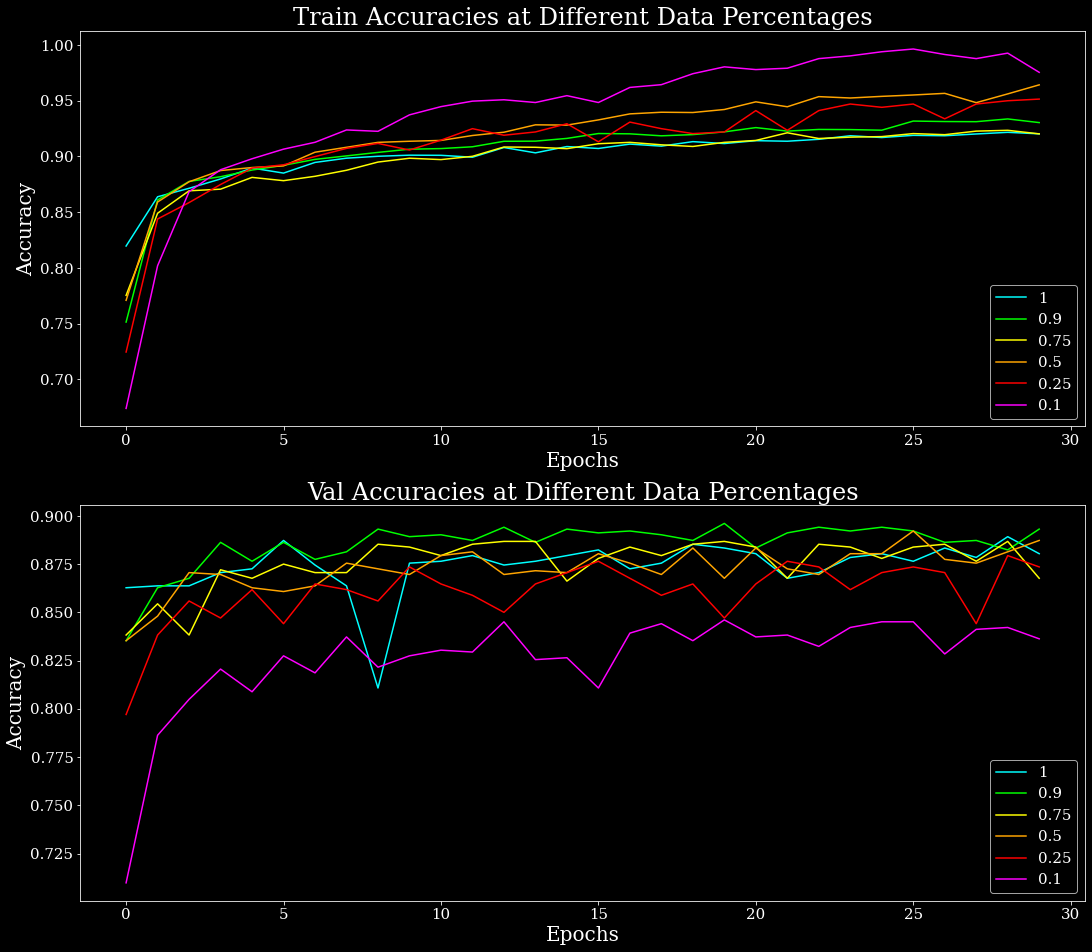

In [26]:
fig, ax = plt.subplots(2, figsize=(18,16))
colors = ["cyan", "lime", "yellow", "orange", "red", "magenta"]

for i in range(len(dataSegments)):
    allAcc = []
    allAccVal = []
    for j in range(len(modelHistories[i])): #get accuracies formatted nicely
        allAcc.append(modelHistories[i][j].history["accuracy"])
        allAccVal.append(modelHistories[i][j].history["val_accuracy"])
    
    avrAcc = np.average(allAcc, axis=0) #average all the accuracies
    avrAccVal = np.average(allAccVal, axis=0) #average all the accuracies
    
    print("Partition:", 100*dataSegments[i], "\b%, Train Acc: ", avrAcc[-1], "Val Acc: ", avrAccVal[-1])
    
    ax[0].plot(avrAcc, label=dataSegments[i], color=colors[i])
    ax[1].plot(avrAccVal, label=dataSegments[i], color=colors[i])
    
    
ax[0].set_title("Train Accuracies at Different Data Percentages", fontsize = 24)
ax[1].set_title("Val Accuracies at Different Data Percentages", fontsize = 24)

for i in range(2):
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].legend(loc = 'lower right', fontsize = 15)
    ax[i].set_xlabel("Epochs", fontsize = 20)
    ax[i].set_ylabel("Accuracy", fontsize = 20)

### Same thing but regression

In [27]:
def runIteration(split, epochsCount):
    
    #reload the data, (ensures data is shuffled)
    _, _, _, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
    _, _, _, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
    _, _, _, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)
    
    #transform the data, use pca and mean of fusion/docking
    labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labels,  compoundDataTrain, 
                                                            compoundDataTest, compoundDataValidate,
                                                            endDims=[1,1,2,1,2,3,2,4])
    labelsMeanPCA, trainData = Transformer.useAverageFD(labelsPCA, trainPCA)
    _, testData = Transformer.useAverageFD(labelsPCA, testPCA)
    _, valData = Transformer.useAverageFD(labelsPCA, valPCA)

    #normalize data
    trainData, testData, valData = Transformer.normalizeData(
        trainData, testData, valData, newMean=0, newStd=1)
    
    #split data (0=1)
    trainData = trainData[0: int(split*len(trainData)) , :] #use %
    activitiesTrain = activitiesTrain[0: int(split*len(activitiesTrain))] #use %
    
    print(split, len(trainData), "samples used.")
    
    l1Reg = keras.regularizers.L1(.001)
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False
    )
    inputDim = np.shape(trainData)[1] #how many inputs
    #build and run model
    
    model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(inputDim, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(80, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(120, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(80, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(40, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(1, activation='relu', kernel_regularizer = l1Reg)
        ])

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['MeanSquaredError'])

    history = model.fit(trainData, activitiesTrain, validation_data = (valData, activitiesValidate), 
        epochs=epochsCount, batch_size=4, verbose = 1) #verbose = 0 for no printing
    
    return model, history


dataSegments = [1, .9, .75, .5, .25, .1]
modelHistories = [] #data for each of the models
averageRuns = 3
epochs = 30

for seg in dataSegments:
    segHist = []
    for i in range(averageRuns):
        tempModel, tempHistory = runIteration(seg, epochs)
        
        if(tempHistory.history["mean_squared_error"][-1] >= 12): #terrible train performance, redo
            i = i-1 #don't use this iteration
            continue
            
        print(100*seg, '\b%', i, " iteration:")
        print("Val Error: ", tempHistory.history["val_mean_squared_error"][-1])
        print("Train Error: ", tempHistory.history["mean_squared_error"][-1])
        segHist.append(tempHistory)
    modelHistories.append(segHist) #histories for this partition of data

bcut2d retention: [0.99364773]
	total: 99.364772734123%
chi retention: [0.9541968]
	total: 95.41967968597889%
paoe retention: [0.31495127 0.19509321]
	total: 51.00444836183712%
smr retention: [0.50634726]
	total: 50.63472600031491%
slogp retention: [0.44620276 0.22134465]
	total: 66.75474031900751%
estate_vsa retention: [0.29224011 0.18964809 0.14361318]
	total: 62.55013868306427%
vsa_estate retention: [0.49255304 0.32866098]
	total: 82.12140205622856%
fr retention: [0.32153498 0.12578177 0.09944384 0.0570485 ]
	total: 60.38090943480597%
1 2717 samples used.
Epoch 1/30
680/680 [==============================] - 3s 3ms/step - loss: 8.0653 - mean_squared_error: 5.2140 - val_loss: 6.3015 - val_mean_squared_error: 3.8421
Epoch 2/30
680/680 [==============================] - 2s 3ms/step - loss: 5.5318 - mean_squared_error: 3.2843 - val_loss: 5.6224 - val_mean_squared_error: 3.5614
Epoch 3/30
680/680 [==============================] - 2s 3ms/step - loss: 4.7654 - mean_squared_error: 2.8554 -

Epoch 14/30
680/680 [==============================] - 2s 3ms/step - loss: 2.2030 - mean_squared_error: 1.2940 - val_loss: 3.5128 - val_mean_squared_error: 2.6141
Epoch 15/30
680/680 [==============================] - 2s 3ms/step - loss: 2.0506 - mean_squared_error: 1.1515 - val_loss: 3.3779 - val_mean_squared_error: 2.4825
Epoch 16/30
680/680 [==============================] - 2s 3ms/step - loss: 2.1303 - mean_squared_error: 1.2407 - val_loss: 3.7985 - val_mean_squared_error: 2.9160
Epoch 17/30
680/680 [==============================] - 2s 3ms/step - loss: 2.0165 - mean_squared_error: 1.1388 - val_loss: 3.3708 - val_mean_squared_error: 2.4942
Epoch 18/30
680/680 [==============================] - 2s 3ms/step - loss: 1.9843 - mean_squared_error: 1.1156 - val_loss: 3.6907 - val_mean_squared_error: 2.8189
Epoch 19/30
680/680 [==============================] - 2s 3ms/step - loss: 2.1255 - mean_squared_error: 1.2565 - val_loss: 3.2855 - val_mean_squared_error: 2.4174
Epoch 20/30
680/680 [=

680/680 [==============================] - 2s 3ms/step - loss: 1.6021 - mean_squared_error: 0.7232 - val_loss: 3.5776 - val_mean_squared_error: 2.6984
100% 2  iteration:
Val Error:  2.6983742713928223
Train Error:  0.7231569886207581
bcut2d retention: [0.99364773]
	total: 99.36477273412304%
chi retention: [0.9541968]
	total: 95.419679685979%
paoe retention: [0.31495127 0.19509321]
	total: 51.004448361840836%
smr retention: [0.50634726]
	total: 50.63472600031494%
slogp retention: [0.44620276 0.22134465]
	total: 66.7547403190078%
estate_vsa retention: [0.29224011 0.18964809 0.14361318]
	total: 62.55013868306432%
vsa_estate retention: [0.49255304 0.32866098]
	total: 82.12140205622848%
fr retention: [0.32153498 0.12578177 0.09944384 0.0570485 ]
	total: 60.38090943687617%
0.9 2445 samples used.
Epoch 1/30
612/612 [==============================] - 3s 3ms/step - loss: 8.4848 - mean_squared_error: 5.7504 - val_loss: 6.1767 - val_mean_squared_error: 3.8495
Epoch 2/30
612/612 [=================

612/612 [==============================] - 2s 3ms/step - loss: 2.5433 - mean_squared_error: 1.3734 - val_loss: 3.7548 - val_mean_squared_error: 2.5998
Epoch 13/30
612/612 [==============================] - 2s 3ms/step - loss: 2.4286 - mean_squared_error: 1.2883 - val_loss: 3.7593 - val_mean_squared_error: 2.6258
Epoch 14/30
612/612 [==============================] - 2s 3ms/step - loss: 2.4475 - mean_squared_error: 1.3275 - val_loss: 3.8639 - val_mean_squared_error: 2.7482
Epoch 15/30
612/612 [==============================] - 2s 3ms/step - loss: 2.3460 - mean_squared_error: 1.2422 - val_loss: 3.6966 - val_mean_squared_error: 2.6056
Epoch 16/30
612/612 [==============================] - 2s 3ms/step - loss: 2.3371 - mean_squared_error: 1.2535 - val_loss: 3.6579 - val_mean_squared_error: 2.5771
Epoch 17/30
612/612 [==============================] - 2s 3ms/step - loss: 2.2003 - mean_squared_error: 1.1301 - val_loss: 3.9626 - val_mean_squared_error: 2.9006
Epoch 18/30
612/612 [=============

Epoch 28/30
612/612 [==============================] - 2s 4ms/step - loss: 22.9926 - mean_squared_error: 22.9872 - val_loss: 22.8077 - val_mean_squared_error: 22.8023
Epoch 29/30
612/612 [==============================] - 2s 3ms/step - loss: 22.9926 - mean_squared_error: 22.9872 - val_loss: 22.8076 - val_mean_squared_error: 22.8023
Epoch 30/30
612/612 [==============================] - 2s 3ms/step - loss: 22.9926 - mean_squared_error: 22.9872 - val_loss: 22.8076 - val_mean_squared_error: 22.8023
bcut2d retention: [0.99364773]
	total: 99.3647727341232%
chi retention: [0.9541968]
	total: 95.41967968597899%
paoe retention: [0.31495127 0.19509321]
	total: 51.0044483618523%
smr retention: [0.50634726]
	total: 50.63472600031501%
slogp retention: [0.44620276 0.22134465]
	total: 66.75474031900757%
estate_vsa retention: [0.29224011 0.18964809 0.14361318]
	total: 62.550138683064304%
vsa_estate retention: [0.49255304 0.32866098]
	total: 82.12140205622833%
fr retention: [0.32153498 0.12578177 0.09

Epoch 11/30
510/510 [==============================] - 2s 4ms/step - loss: 2.6601 - mean_squared_error: 1.3904 - val_loss: 4.1379 - val_mean_squared_error: 2.8907
Epoch 12/30
510/510 [==============================] - 2s 3ms/step - loss: 2.6314 - mean_squared_error: 1.4058 - val_loss: 3.8626 - val_mean_squared_error: 2.6585
Epoch 13/30
510/510 [==============================] - 2s 3ms/step - loss: 2.4425 - mean_squared_error: 1.2533 - val_loss: 3.7666 - val_mean_squared_error: 2.6029
Epoch 14/30
510/510 [==============================] - 2s 3ms/step - loss: 2.3627 - mean_squared_error: 1.2134 - val_loss: 4.0807 - val_mean_squared_error: 2.9403
Epoch 15/30
510/510 [==============================] - 2s 3ms/step - loss: 2.2845 - mean_squared_error: 1.1562 - val_loss: 3.8252 - val_mean_squared_error: 2.7070
Epoch 16/30
510/510 [==============================] - 2s 3ms/step - loss: 2.1477 - mean_squared_error: 1.0471 - val_loss: 4.1853 - val_mean_squared_error: 3.0939
Epoch 17/30
510/510 [=

Epoch 27/30
510/510 [==============================] - 4s 7ms/step - loss: 22.6284 - mean_squared_error: 22.6230 - val_loss: 22.8077 - val_mean_squared_error: 22.8023
Epoch 28/30
510/510 [==============================] - 3s 7ms/step - loss: 22.6284 - mean_squared_error: 22.6230 - val_loss: 22.8077 - val_mean_squared_error: 22.8023
Epoch 29/30
510/510 [==============================] - 3s 7ms/step - loss: 22.6284 - mean_squared_error: 22.6230 - val_loss: 22.8077 - val_mean_squared_error: 22.8023
Epoch 30/30
510/510 [==============================] - 4s 7ms/step - loss: 22.6284 - mean_squared_error: 22.6230 - val_loss: 22.8077 - val_mean_squared_error: 22.8023
bcut2d retention: [0.99364773]
	total: 99.36477273412336%
chi retention: [0.9541968]
	total: 95.41967968597889%
paoe retention: [0.31495127 0.19509321]
	total: 51.004448361839636%
smr retention: [0.50634726]
	total: 50.63472600031497%
slogp retention: [0.44620276 0.22134465]
	total: 66.7547403190077%
estate_vsa retention: [0.29224

340/340 [==============================] - 1s 4ms/step - loss: 22.9066 - mean_squared_error: 22.9012 - val_loss: 22.8077 - val_mean_squared_error: 22.8023
Epoch 10/30
340/340 [==============================] - 1s 4ms/step - loss: 22.9066 - mean_squared_error: 22.9012 - val_loss: 22.8076 - val_mean_squared_error: 22.8023
Epoch 11/30
340/340 [==============================] - 1s 4ms/step - loss: 22.9066 - mean_squared_error: 22.9012 - val_loss: 22.8077 - val_mean_squared_error: 22.8023
Epoch 12/30
340/340 [==============================] - 1s 4ms/step - loss: 22.9066 - mean_squared_error: 22.9012 - val_loss: 22.8077 - val_mean_squared_error: 22.8023
Epoch 13/30
340/340 [==============================] - 1s 4ms/step - loss: 22.9066 - mean_squared_error: 22.9012 - val_loss: 22.8076 - val_mean_squared_error: 22.8023
Epoch 14/30
340/340 [==============================] - 1s 4ms/step - loss: 22.9066 - mean_squared_error: 22.9012 - val_loss: 22.8077 - val_mean_squared_error: 22.8023
Epoch 15/3

340/340 [==============================] - 2s 5ms/step - loss: 1.9898 - mean_squared_error: 0.8448 - val_loss: 4.4232 - val_mean_squared_error: 3.2876
Epoch 26/30
340/340 [==============================] - 2s 5ms/step - loss: 1.9572 - mean_squared_error: 0.8316 - val_loss: 3.9952 - val_mean_squared_error: 2.8692
Epoch 27/30
340/340 [==============================] - 2s 5ms/step - loss: 2.0648 - mean_squared_error: 0.9499 - val_loss: 3.9471 - val_mean_squared_error: 2.8402
Epoch 28/30
340/340 [==============================] - 2s 5ms/step - loss: 1.7129 - mean_squared_error: 0.6128 - val_loss: 4.5029 - val_mean_squared_error: 3.4133
Epoch 29/30
340/340 [==============================] - 2s 5ms/step - loss: 1.7176 - mean_squared_error: 0.6338 - val_loss: 4.1708 - val_mean_squared_error: 3.0925
Epoch 30/30
340/340 [==============================] - 2s 5ms/step - loss: 1.5378 - mean_squared_error: 0.4736 - val_loss: 4.4417 - val_mean_squared_error: 3.3861
50.0% 2  iteration:
Val Error:  3.

170/170 [==============================] - 1s 5ms/step - loss: 22.4680 - mean_squared_error: 22.4626 - val_loss: 22.8077 - val_mean_squared_error: 22.8023
Epoch 8/30
170/170 [==============================] - 1s 5ms/step - loss: 22.4680 - mean_squared_error: 22.4626 - val_loss: 22.8077 - val_mean_squared_error: 22.8023
Epoch 9/30
170/170 [==============================] - 1s 5ms/step - loss: 22.4680 - mean_squared_error: 22.4627 - val_loss: 22.8077 - val_mean_squared_error: 22.8023
Epoch 10/30
170/170 [==============================] - 1s 5ms/step - loss: 22.4680 - mean_squared_error: 22.4626 - val_loss: 22.8077 - val_mean_squared_error: 22.8023
Epoch 11/30
170/170 [==============================] - 1s 5ms/step - loss: 22.4680 - mean_squared_error: 22.4626 - val_loss: 22.8077 - val_mean_squared_error: 22.8023
Epoch 12/30
170/170 [==============================] - 1s 5ms/step - loss: 22.4680 - mean_squared_error: 22.4626 - val_loss: 22.8077 - val_mean_squared_error: 22.8023
Epoch 13/30


170/170 [==============================] - 1s 5ms/step - loss: 2.9299 - mean_squared_error: 1.2210 - val_loss: 5.3686 - val_mean_squared_error: 3.6753
Epoch 24/30
170/170 [==============================] - 1s 5ms/step - loss: 2.2775 - mean_squared_error: 0.6038 - val_loss: 5.0430 - val_mean_squared_error: 3.3892
Epoch 25/30
170/170 [==============================] - 1s 5ms/step - loss: 2.1149 - mean_squared_error: 0.4821 - val_loss: 5.1100 - val_mean_squared_error: 3.4953
Epoch 26/30
170/170 [==============================] - 1s 5ms/step - loss: 2.0668 - mean_squared_error: 0.4710 - val_loss: 4.9052 - val_mean_squared_error: 3.3224
Epoch 27/30
170/170 [==============================] - 1s 5ms/step - loss: 1.9881 - mean_squared_error: 0.4203 - val_loss: 4.7622 - val_mean_squared_error: 3.2086
Epoch 28/30
170/170 [==============================] - 1s 5ms/step - loss: 2.0051 - mean_squared_error: 0.4687 - val_loss: 4.9999 - val_mean_squared_error: 3.4783
Epoch 29/30
170/170 [=============

68/68 [==============================] - 1s 7ms/step - loss: 4.3552 - mean_squared_error: 3.0983 - val_loss: 6.4404 - val_mean_squared_error: 5.2088
Epoch 6/30
68/68 [==============================] - 1s 8ms/step - loss: 4.0450 - mean_squared_error: 2.8246 - val_loss: 5.4051 - val_mean_squared_error: 4.1956
Epoch 7/30
68/68 [==============================] - 0s 7ms/step - loss: 3.6632 - mean_squared_error: 2.4625 - val_loss: 5.6511 - val_mean_squared_error: 4.4583
Epoch 8/30
68/68 [==============================] - 0s 7ms/step - loss: 3.2784 - mean_squared_error: 2.0957 - val_loss: 5.5932 - val_mean_squared_error: 4.4183
Epoch 9/30
68/68 [==============================] - 0s 7ms/step - loss: 3.0727 - mean_squared_error: 1.9048 - val_loss: 7.2126 - val_mean_squared_error: 6.0471
Epoch 10/30
68/68 [==============================] - 0s 7ms/step - loss: 3.0154 - mean_squared_error: 1.8611 - val_loss: 6.1341 - val_mean_squared_error: 4.9866
Epoch 11/30
68/68 [==============================]

Epoch 22/30
68/68 [==============================] - 0s 6ms/step - loss: 2.7162 - mean_squared_error: 0.5809 - val_loss: 7.0497 - val_mean_squared_error: 4.9322
Epoch 23/30
68/68 [==============================] - 1s 8ms/step - loss: 2.5013 - mean_squared_error: 0.4012 - val_loss: 7.3601 - val_mean_squared_error: 5.2754
Epoch 24/30
68/68 [==============================] - 1s 8ms/step - loss: 3.0033 - mean_squared_error: 0.9248 - val_loss: 7.4779 - val_mean_squared_error: 5.4112
Epoch 25/30
68/68 [==============================] - 0s 7ms/step - loss: 2.6237 - mean_squared_error: 0.5730 - val_loss: 6.6289 - val_mean_squared_error: 4.5931
Epoch 26/30
68/68 [==============================] - 0s 7ms/step - loss: 2.3390 - mean_squared_error: 0.3175 - val_loss: 7.1312 - val_mean_squared_error: 5.1256
Epoch 27/30
68/68 [==============================] - 0s 7ms/step - loss: 2.1335 - mean_squared_error: 0.1471 - val_loss: 6.8182 - val_mean_squared_error: 4.8490
Epoch 28/30
68/68 [===============

Partition: 100 %, Train Err:  0.8124575813611349 Val Err:  2.8074042797088623
Partition: 90.0 %, Train Err:  0.7209060788154602 Val Err:  3.0053186416625977
Partition: 75.0 %, Train Err:  0.8080130815505981 Val Err:  2.900327682495117
Partition: 50.0 %, Train Err:  0.6190817505121231 Val Err:  3.4158694744110107
Partition: 25.0 %, Train Err:  0.32622307538986206 Val Err:  3.3557066917419434
Partition: 10.0 %, Train Err:  0.2969755232334137 Val Err:  4.58398175239563


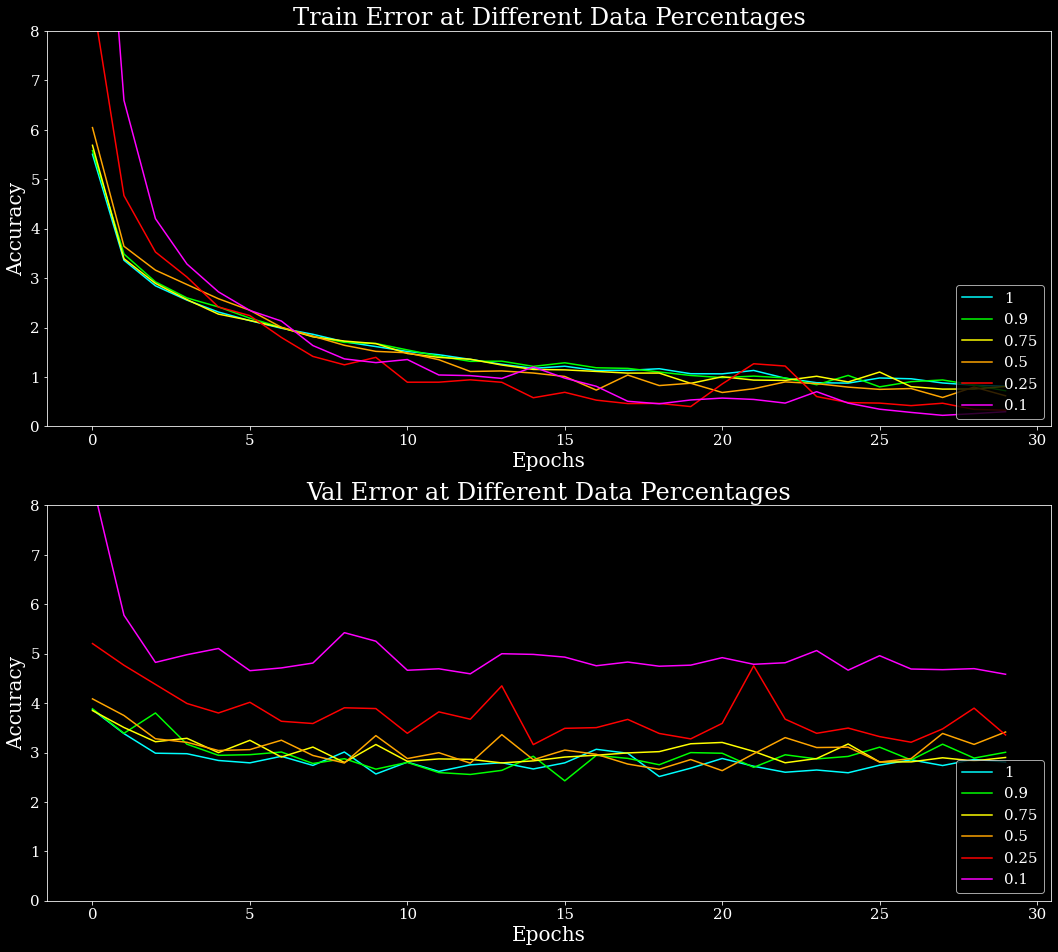

In [29]:
fig, ax = plt.subplots(2, figsize=(18,16))
colors = ["cyan", "lime", "yellow", "orange", "red", "magenta"]

for i in range(len(dataSegments)):
    allErr = []
    allErrVal = []
    for j in range(len(modelHistories[i])): #get accuracies formatted nicely
        allErr.append(modelHistories[i][j].history["mean_squared_error"])
        allErrVal.append(modelHistories[i][j].history["val_mean_squared_error"])
    
    avrErr = np.average(allErr, axis=0) #average all the accuracies
    avrErrVal = np.average(allErrVal, axis=0) #average all the accuracies
    
    print("Partition:", 100*dataSegments[i], "\b%, Train Err: ", avrErr[-1], "Val Err: ", avrErrVal[-1])
    
    ax[0].plot(avrErr, label=dataSegments[i], color=colors[i])
    ax[1].plot(avrErrVal, label=dataSegments[i], color=colors[i])
    
    
ax[0].set_title("Train Error at Different Data Percentages", fontsize = 24)
ax[1].set_title("Val Error at Different Data Percentages", fontsize = 24)

for i in range(2):
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].legend(loc = 'lower right', fontsize = 15)
    ax[i].set_xlabel("Epochs", fontsize = 20)
    ax[i].set_ylabel("Accuracy", fontsize = 20)
    ax[i].set_ylim([0,8])